# Udacity Data Analyst Nanodegree
# P5: Identify Fraud from Enron Email

Author: Luiz Gerosa

Date: April 26, 2017

## Project Overview
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

The goal of this project is to build a person of interest (POI) identifier using machine learning.

### Person of Interest
A person of interest is an individual who was indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. The list of POI used in this project was hand-generated by Udacity team through information found on [news articles](http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm). Below is the list of all POI found.

In [1]:
from pprint import pprint
poi_list = ['Lay, Kenneth','Skilling, Jeffrey','Howard, Kevin','Krautz, Michael','Yeager, Scott','Hirko, Joseph','Shelby, Rex','Bermingham, David','Darby, Giles','Mulgrew, Gary','Bayley, Daniel','Brown, James','Furst, Robert','Fuhs, William','Causey, Richard','Calger, Christopher','DeSpain, Timothy','Hannon, Kevin','Koenig, Mark','Forney, John','Rice, Kenneth','Rieker, Paula','Fastow, Lea','Fastow, Andrew','Delainey, David','Glisan, Ben','Richter, Jeffrey','Lawyer, Larry','Belden, Timothy','Kopper, Michael','Duncan, David','Bowen, Raymond','Colwell, Wesley','Boyle, Dan','Loehr, Christopher']
pprint(poi_list)

['Lay, Kenneth',
 'Skilling, Jeffrey',
 'Howard, Kevin',
 'Krautz, Michael',
 'Yeager, Scott',
 'Hirko, Joseph',
 'Shelby, Rex',
 'Bermingham, David',
 'Darby, Giles',
 'Mulgrew, Gary',
 'Bayley, Daniel',
 'Brown, James',
 'Furst, Robert',
 'Fuhs, William',
 'Causey, Richard',
 'Calger, Christopher',
 'DeSpain, Timothy',
 'Hannon, Kevin',
 'Koenig, Mark',
 'Forney, John',
 'Rice, Kenneth',
 'Rieker, Paula',
 'Fastow, Lea',
 'Fastow, Andrew',
 'Delainey, David',
 'Glisan, Ben',
 'Richter, Jeffrey',
 'Lawyer, Larry',
 'Belden, Timothy',
 'Kopper, Michael',
 'Duncan, David',
 'Bowen, Raymond',
 'Colwell, Wesley',
 'Boyle, Dan',
 'Loehr, Christopher']


## Exploratory Analysis

The dataset for this project was generated by Udacity team combining [Enron email](https://www.cs.cmu.edu/~./enron/) and [financial data]('./final_project/enron61702insiderpay.pdf') into a dictionary, where each key-value pair in the dictionary corresponds to one person. It's beyond the scope of this project to reproduce the steps necessary to generate the dataset.

To make the analysis easier, the Panda library was used to extract characteristics from the dataset.

In [2]:
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

### Load the dictionary containing the dataset
with open("final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame(data_dict)
df = df.transpose()
df.sort_index(ascending=True, inplace=True)

# replace 'NaN' with Numpy's NaN
df.replace('NaN', np.nan, inplace=True)
df.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                 object
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                             bool
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

There are 146 observations, 20 features and 1 label in the dataset.

In [3]:
print('Observations: {}'.format(df.shape[0]))
print('Features: {}'.format(df.shape[1] - 1))

Observations: 146
Features: 20


The chart below shows the distribution between POIs and non-POIs

Number of POIs: 18
Number of non-POIs: 128


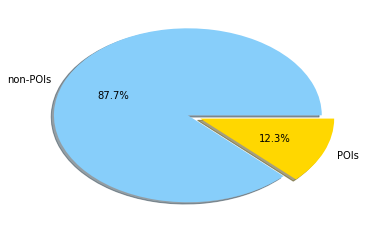

In [4]:
counts = df.groupby('poi').size()

non_poi_count = counts[0]
poi_count = counts[1]

print('Number of POIs: {}'.format(poi_count))
print('Number of non-POIs: {}'.format(non_poi_count))

colors = ['lightskyblue','gold']
labels=['non-POIs', 'POIs']
explode = (0.1, 0)

plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True);


As can be observed, the number of non-POIs is much higher than the number of POIs. When the number of instances of one class far exceeds the other, classification models could have problems due to a phenomenon called [class imbalance](http://www.chioka.in/class-imbalance-problem/). To handle this problem, the hyperparameters will be tuned to maximize the F1 score rather than the accuracy. 

### Financial Features

There are 14 financial features. All units are US dollars.

In [5]:
financial_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
df[financial_features].head()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
ALLEN PHILLIP K,201955.0,4175000.0,304805.0,-3081055.0,2869717.0,NaN,152.0,13868.0,NaN,4484442.0,1729541.0,126027.0,-126027.0,1729541.0
BADUM JAMES P,NaN,NaN,NaN,NaN,178980.0,NaN,NaN,3486.0,NaN,182466.0,257817.0,NaN,NaN,257817.0
BANNANTINE JAMES M,477.0,NaN,NaN,-5104.0,NaN,NaN,864523.0,56301.0,NaN,916197.0,4046157.0,1757552.0,-560222.0,5243487.0
BAXTER JOHN C,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,NaN,2660303.0,11200.0,NaN,5634343.0,6680544.0,3942714.0,NaN,10623258.0
BAY FRANKLIN R,239671.0,400000.0,NaN,-201641.0,260455.0,NaN,69.0,129142.0,NaN,827696.0,NaN,145796.0,-82782.0,63014.0


Feature | Description 
:--- | :--- 
salary | Reflects items such as base salary, executive cash allowances, and benefits payments.
bonus  | Reflects annual cash incentives paid based upon company performance. Also, may include other retention payments.
long_term_incentive | Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.
deferred_income | Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.
deferral_payments | Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.
loan_advances | Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company.
other | Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft.
expenses | Reflects reimbursements of business expenses. May include fees paid for consulting services.
director_fees | Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.
total_payments | Total payments received
exercised_stock_options | Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities.
restricted_stock | Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting periods, regardless of whether deferred.
restricted_stock_deferred | Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.
total_stock_value | Total stock value

### Email Features
There are 6 e-mail features.

In [6]:
email_features = ['email_address', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

df[email_features].head()

,email_address,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
ALLEN PHILLIP K,phillip.allen@enron.com,2902.0,47.0,2195.0,65.0,1407.0
BADUM JAMES P,NaN,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,james.bannantine@enron.com,566.0,39.0,29.0,0.0,465.0
BAXTER JOHN C,NaN,NaN,NaN,NaN,NaN,NaN
BAY FRANKLIN R,frank.bay@enron.com,NaN,NaN,NaN,NaN,NaN


Feature | Description
:-------| :----------
email_address | E-mail address
to_messages | Number of e-mails this person received
from_poi_to_this_person | Number of e-mails a POI sent to this person
from_messages | Number of e-mails this person sent
from_this_person_to_poi | Number of e-mails this person sent to a POI
shared_receipt_with_poi | Number of e-mails this person was c.c. with a POI

### Outliers
The dataset contains a huge outlier as can be observed plotting the *salary* and *bonus* features:

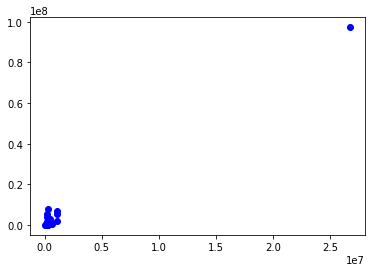

In [7]:
plt.scatter(df['salary'], df['bonus'], color = "b");

This outlier is actually a bug in the parser of the financial PDF that extracts the row "TOTAL" as a person.

In [8]:
display(df[df['salary'] > 1e+07])
df.drop('TOTAL', inplace=True)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,NaN,311764000.0,5235198.0,NaN,NaN,NaN,...,48521928.0,42667589.0,False,130322299.0,-7576788.0,26704229.0,NaN,NaN,309886585.0,434509511.0


Another observation that can be removed after a manual review of the dataset is the _"THE TRAVEL AGENCY IN THE PARK"_ which is clearly not a person.

In [9]:
display(df.loc[['THE TRAVEL AGENCY IN THE PARK']])
df.drop('THE TRAVEL AGENCY IN THE PARK', inplace=True)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
THE TRAVEL AGENCY IN THE PARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,362096.0,False,NaN,NaN,NaN,NaN,NaN,362096.0,NaN


Finally, there is one observation which all values are missing

In [10]:
display(df[df.isnull().sum(axis = 1) > 18])
df.drop('LOCKHART EUGENE E', inplace=True)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Values
The list below shows the number of missing values per feature.

In [11]:
df.isnull().sum()

bonus                         62
deferral_payments            105
deferred_income               95
director_fees                127
email_address                 32
exercised_stock_options       42
expenses                      49
from_messages                 57
from_poi_to_this_person       57
from_this_person_to_poi       57
loan_advances                140
long_term_incentive           78
other                         52
poi                            0
restricted_stock              34
restricted_stock_deferred    126
salary                        49
shared_receipt_with_poi       57
to_messages                   57
total_payments                20
total_stock_value             18
dtype: int64

In the case of this dataset, the NaN values should be replaced by 0, as discussed [here](https://discussions.udacity.com/t/what-is-the-proper-way-to-handle-nan/24593)


In [12]:
df.replace(np.nan, 0.0, inplace=True)

## Feature Selection/Engineering

### E-mail address
The *email_address* is an identifier, so it needs to be removed.

In [13]:
df.drop('email_address', axis=1, inplace=True)
email_features.remove('email_address') 

### E-mails exchanged with POI
A set of features that might help to predict POIs is the *from_poi_to_this_person* and *from_this_person_to_poi*. The scatter plot below shows the relation of these features and POI.

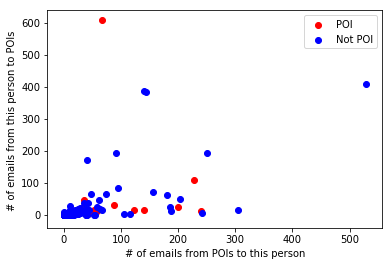

In [14]:
plt.scatter(df[df['poi']]['from_poi_to_this_person'], df[df['poi']]['from_this_person_to_poi'], color = "r", label="POI")
plt.scatter(df[df['poi'] == False]['from_poi_to_this_person'], df[df['poi'] == False]['from_this_person_to_poi'], color = "b", label="Not POI")
plt.xlabel('# of emails from POI''s to this person')
plt.ylabel('# of emails from this person to POI''s ')
plt.legend();

As can be observed, the total number of e-mails is not that helpfull to identify POI's. But the rate of e-mails gives a better result:

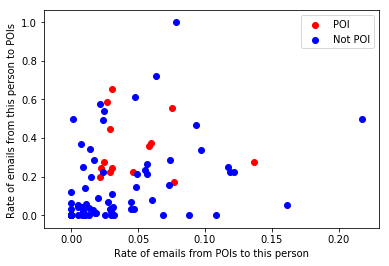

In [15]:
df = df.assign(fraction_to_poi = df['from_this_person_to_poi'].divide(df['from_messages']).replace(np.nan, 0.))
df = df.assign(fraction_from_poi = df['from_poi_to_this_person'].divide(df['to_messages']).replace(np.nan, 0.))
email_features.append('fraction_to_poi')
email_features.append('fraction_from_poi')

plt.scatter(df[df['poi']]['fraction_from_poi'], df[df['poi']]['fraction_to_poi'], color = "r", label="POI")
plt.scatter(df[df['poi'] == False]['fraction_from_poi'], df[df['poi'] == False]['fraction_to_poi'], color = "b", label="Not POI")
plt.xlabel('Rate of emails from POI''s to this person')
plt.ylabel('Rate of emails from this person to POI''s ')
plt.legend()

### Feature Importance
The code below calculates the importance of each features for the classification task.

In [16]:
def targetFeatureSplit(df, label, features_list):
    labels = df[label].values.astype(bool)
    features = df[features_list].values 

    return labels, features

features_list = financial_features + email_features
labels, features = targetFeatureSplit(df, 'poi', features_list)

from sklearn.feature_selection import SelectKBest
selector = SelectKBest()
selector.fit(features, labels)

features_score = pd.Series(selector.scores_, index=features_list).sort_values(ascending=False)

print(features_score)

exercised_stock_options      24.815080
total_stock_value            24.182899
bonus                        20.792252
salary                       18.289684
fraction_to_poi              16.409713
deferred_income              11.458477
long_term_incentive           9.922186
restricted_stock              9.212811
total_payments                8.772778
shared_receipt_with_poi       8.589421
loan_advances                 7.184056
expenses                      6.094173
from_poi_to_this_person       5.243450
other                         4.187478
fraction_from_poi             3.128092
from_this_person_to_poi       2.382612
director_fees                 2.126328
to_messages                   1.646341
deferral_payments             0.224611
from_messages                 0.169701
restricted_stock_deferred     0.065500
dtype: float64


The new features created *fraction_to_poi* and *fraction_from_poi* have better score than the orginals features *from_this_person_to_poi* and *from_poi_to_this_person*. So the original features were removed from the dataset. 

In [17]:
df.drop(['from_this_person_to_poi', 'from_poi_to_this_person'], axis=1, inplace=True)
email_features.remove('from_this_person_to_poi')
email_features.remove('from_poi_to_this_person') 


features_list = financial_features + email_features
labels, features = targetFeatureSplit(df, 'poi', features_list)

All other features were kept in the dataset. The best features will be selected automatically by [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) as part of a greater pipeline used to train several classifiers (check Machine Learning Algorithm session).

### Feature Scaling
The main reasoning for using or not using feature scaling is really depending on the algorithm. The scaled version of the features was calculated using [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for comparison with and without the scaled features in the next session. 

In [18]:
from sklearn.preprocessing import MinMaxScaler

std_scale = MinMaxScaler().fit(features)
features_scaled = std_scale.transform(features)

## Machine Learning Algorithm
In order to choose the best algorithm, the performance of 3 different algorithms was compared: Naive Bayes, Decision Tree, and Logistic Regression.

### Parameter Tuning Strategy

Tuning the parameters of an algorithm means adjusting the parameters in a certain way to achieve optimal performance. If the parameters are not tuned well, performance may suffer. The data won't be "learned" well and the algorithm won't be able to successfully make predictions on new data.

The tuning process could be very time-consuming and tedious if done manually. In order to automate this process, it was used [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which allow to test all the combinations of parameters and then report back the best one.

As mentioned earlier, the selection of the best features was added as part of the tuning process using a [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with two steps: first, the _k_ best features are selected using [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) and next, the classification task is performed. Then, GridSearchCV was used to find the best _k_ value and the best algorithm parameters.

In [19]:
results = pd.DataFrame({}, columns=['precision', 'recall', 'f1_score']) 

In [26]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit


# split the dataset between training and test sets
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

features_scaled_train, features_scaled_test, labels_train, labels_test = \
    train_test_split(features_scaled, labels, test_size=0.3, random_state=42)


def evaluateClassifier(name, clf, parameters, scaled, results):
    
    select = SelectKBest()
    
    steps = [
        ('feature_selection', select),
        ('classification', clf)]


    pipeline = Pipeline(steps)

    cv = StratifiedShuffleSplit(labels_train, 100, random_state = 42)
    clf = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=cv)
    
    
    if scaled:
        print('Using scaled features')
        clf.fit(features_scaled_train, labels_train)
        predictions = clf.predict(features_scaled_test)
    else:
        print('Using original features')
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)

    print(clf.best_params_)
    report = classification_report( labels_test, predictions )
    
    print(report)
    
    # save the algorithm performance
    results.loc[name] = [
        precision_score(labels_test, predictions),
        recall_score(labels_test, predictions),
        f1_score(labels_test, predictions)]
    


### Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

parameters = dict(feature_selection__k = range(1,len(features_list)))

clf = GaussianNB()
evaluateClassifier('Naive Bayes', clf, parameters, False, results)

clf = GaussianNB()
evaluateClassifier('Naive Bayes Scaled', clf, parameters, True, results)

Using original features
{'feature_selection__k': 18}
             precision    recall  f1-score   support

      False       0.92      0.95      0.94        38
       True       0.50      0.40      0.44         5

avg / total       0.87      0.88      0.88        43

Using scaled features
{'feature_selection__k': 17}
             precision    recall  f1-score   support

      False       0.96      0.58      0.72        38
       True       0.20      0.80      0.32         5

avg / total       0.87      0.60      0.67        43



Using the scaled features, the recall score increased from .4 to .8, but the precision score dropped from .5 to .2. Overall, the algorithm performed worse using scaled features because the F1 score dropped from .44 to .32.

### Decision Tree

Searching for the best parameters.

In [22]:
from sklearn import tree



parameters = dict(feature_selection__k=range(1,len(features_list)),
                 classification__min_samples_split=range(10,25,5),
                 classification__criterion=['gini', 'entropy'])

clf = tree.DecisionTreeClassifier()
evaluateClassifier('Decision Tree', clf, parameters, False, results)

clf = tree.DecisionTreeClassifier()
evaluateClassifier('Decision Tree Scaled', clf, parameters, True, results)

Using original features
{'feature_selection__k': 6, 'classification__min_samples_split': 20, 'classification__criterion': 'entropy'}
             precision    recall  f1-score   support

      False       0.97      0.87      0.92        38
       True       0.44      0.80      0.57         5

avg / total       0.91      0.86      0.88        43

Using scaled features
{'feature_selection__k': 17, 'classification__min_samples_split': 15, 'classification__criterion': 'entropy'}
             precision    recall  f1-score   support

      False       0.97      0.89      0.93        38
       True       0.50      0.80      0.62         5

avg / total       0.92      0.88      0.89        43



The algorithm performance was slightly better using the scaled features.

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression


parameters = dict(feature_selection__k = range(1,len(features_list)),
                 classification__C = [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                 classification__penalty = ['l1', 'l2'])

clf = LogisticRegression()
evaluateClassifier('Logistic Regression', clf, parameters, False, results)

clf = LogisticRegression()
evaluateClassifier('Logistic Regression Scaled', clf, parameters, True, results)

Using original features
{'feature_selection__k': 12, 'classification__C': 1, 'classification__penalty': 'l1'}
             precision    recall  f1-score   support

      False       0.90      0.97      0.94        38
       True       0.50      0.20      0.29         5

avg / total       0.86      0.88      0.86        43

Using scaled features
{'feature_selection__k': 11, 'classification__C': 1000, 'classification__penalty': 'l1'}
             precision    recall  f1-score   support

      False       0.90      0.95      0.92        38
       True       0.33      0.20      0.25         5

avg / total       0.83      0.86      0.84        43



The algorithm performed worse using scaled features.

## Results
### Validation Strategy

Validation is a way to substantiate your machine learning algorithm's performance, i.e., to test how well your model has been trained. A classic validation mistake is testing your algorithm on the same data that is was trained on. Without separating the training set from the testing set, it is difficult to determine how well your algorithm generalizes to new data.

In this project, the dataset was first split between a training set (67%) and test set (33%). Next, cross-validation was used to find the best-fitting parameters using the training partition (lower-left partition in the figure below) and then the model's performance was assessed on the test partition (lower-right).

![alt text](data_split.png "Dataset split")

The [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) cross validation was used to guard against bias introduced by the potential underrepresentation of classes (i.e. POIs).


### Evaluation Metrics
The metrics used to evaluate the algorithm performance are described below:

Metric | Description
:----- | :----------
Precision| Measures the percentage of individuals that the algorithm correctly classified as POI amongst all positive predictions 
Recall | Measures the percentage of individuals that the algorithm correctly classified as POIs amongst all real POIs
F1 | Weighted average of the precision and recall


The table below shows the results of the algorithm performance. 

In [24]:
results.sort_values('f1_score', ascending=False)

,precision,recall,f1_score
Decision Tree Scaled,0.500000,0.8,0.615385
Decision Tree,0.444444,0.8,0.571429
Naive Bayes,0.500000,0.4,0.444444
Naive Bayes Scaled,0.200000,0.8,0.320000
Logistic Regression,0.500000,0.2,0.285714
Logistic Regression Scaled,0.333333,0.2,0.250000


The winner algorithm was Decision Tree with scaled features!